In [1]:
import json
import pandas as pd
import glob as glob
from scipy import stats

methods = {
    "Baseline": "qwen-2.5-x.5B-instruct-countdown-baseline",
    "OP": "qwen-2.5-x.5B-instruct-sft-lora-countdown-optimal-seq8k-5k",
    "SoS": "qwen-2.5-x.5B-instruct-sft-lora-countdown-search-seq8k-5k", 
    # "RSoS": "qwen-2.5-x.5B-instruct-sft-lora-countdown-search-react-seq8k-5k", 
    "RSoS$\u2021$": "qwen-2.5-x.5B-instruct-sft-lora-countdown-search-react-correct-seq10k-5k", 
    "Distill": "qwen-2.5-x.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-5k"
}

tasks = {
    "Countdown": "test_128", 
    "Countdown-3": "countdown_3num_128", 
    "Countdown-5": "countdown_5num_128",
    "KnK": "knk"
}

sizes = ["0.5B", "1.5B"]

def binomial_ci(success, total, confidence=0.66):
    """Calculate binomial proportion confidence interval using Wilson score interval via stats.binomtest"""
    if total == 0:
        return 0
    
    # Use stats.binomtest for computing CI with Wilson method
    test = stats.binomtest(int(success), int(total))
    ci = test.proportion_ci(confidence_level=confidence, method="wilson")
    
    # Calculate margin of error (half the width of the interval)
    margin = (ci.high - ci.low) / 2 * 100  # Convert to percentage
    
    return margin

def parse_results_from_json(file):
    try:
        with open(file, 'r') as f:
            data = json.load(f)
            
        if "knk" in file:
            score = data["scores"]["2ppl"]
            score_ = score/100  # This is out of 1
            score_ = score_*200  # Because there are 200 samples
            
            return score, binomial_ci(score_, 200)   
        
        if "countdown" in file or "test" in file:
            score = data[1]['mean']*128  # number of correct samples
            return data[1]['mean']*100, binomial_ci(score, 128) 
    
    except Exception as e:
        print("Error reading file:", file)
        print("Error message:", e)
        return None, None

# Initialize results and confidence intervals
results = {size: {method_key: {task_key: None for task_key in tasks.keys()} for method_key in methods.keys()} for size in sizes}
ci = {size: {method_key: {task_key: None for task_key in tasks.keys()} for method_key in methods.keys()} for size in sizes}

# Gather results
for size_val in sizes:
    for method_key, method_val in methods.items():
        for task_key, task_val in tasks.items():
            folder_to_look_for = f"./{method_val}/{task_val}*.json".replace("x.5B", size_val) 
            specific_file = glob.glob(folder_to_look_for)
            if specific_file:
                results[size_val][method_key][task_key], ci[size_val][method_key][task_key] = parse_results_from_json(specific_file[0])

# Create DataFrames
df_results = pd.DataFrame.from_dict({(i, j): results[i][j]
                           for i in results.keys() 
                           for j in results[i].keys()},
                           orient='index')

df_ci = pd.DataFrame.from_dict({(i, j): ci[i][j]
                           for i in ci.keys() 
                           for j in ci[i].keys()},
                           orient='index')

# Transpose
df_results = df_results.transpose()
df_ci = df_ci.transpose()

# Create a combined DataFrame with results ± CI
df_combined = pd.DataFrame(index=df_results.index, columns=df_results.columns)

for index in df_results.index:
    for column in df_results.columns:
        result = df_results.loc[index, column]
        conf_interval = df_ci.loc[index, column]
        
        if result is not None and conf_interval is not None:
            # Format as "result ± CI" with 2 decimal places
            df_combined.loc[index, column] = f"{result:.2f} ± {conf_interval:.2f}"
        else:
            df_combined.loc[index, column] = "N/A"

# Export to LaTeX with escape=False to preserve ± symbol
df_combined.to_latex("results_with_ci.tex", index=True, escape=False)

print(df_combined)

                    0.5B                                          \
                Baseline           OP           SoS      RSoS$‡$   
Countdown    0.00 ± 0.35  2.34 ± 1.32  37.50 ± 4.07  0.78 ± 0.82   
Countdown-3  0.00 ± 0.35  1.56 ± 1.10  33.59 ± 3.97  0.00 ± 0.35   
Countdown-5  0.00 ± 0.35  0.78 ± 0.82   0.00 ± 0.35  0.00 ± 0.35   
KnK          1.00 ± 0.71  1.50 ± 0.85   0.00 ± 0.23  0.00 ± 0.23   

                                  1.5B                             \
                  Distill     Baseline           OP           SoS   
Countdown    25.78 ± 3.68  0.78 ± 0.82  5.47 ± 1.94  49.22 ± 4.20   
Countdown-3  42.97 ± 4.16  3.12 ± 1.50  4.69 ± 1.80  57.81 ± 4.15   
Countdown-5   0.78 ± 0.82  0.00 ± 0.35  0.78 ± 0.82   0.00 ± 0.35   
KnK           1.50 ± 0.85  7.00 ± 1.73  2.50 ± 1.07   0.00 ± 0.23   

                                         
                  RSoS$‡$       Distill  
Countdown    52.34 ± 4.20  44.53 ± 4.18  
Countdown-3  62.50 ± 4.07  71.09 ± 3.81  
Countdow

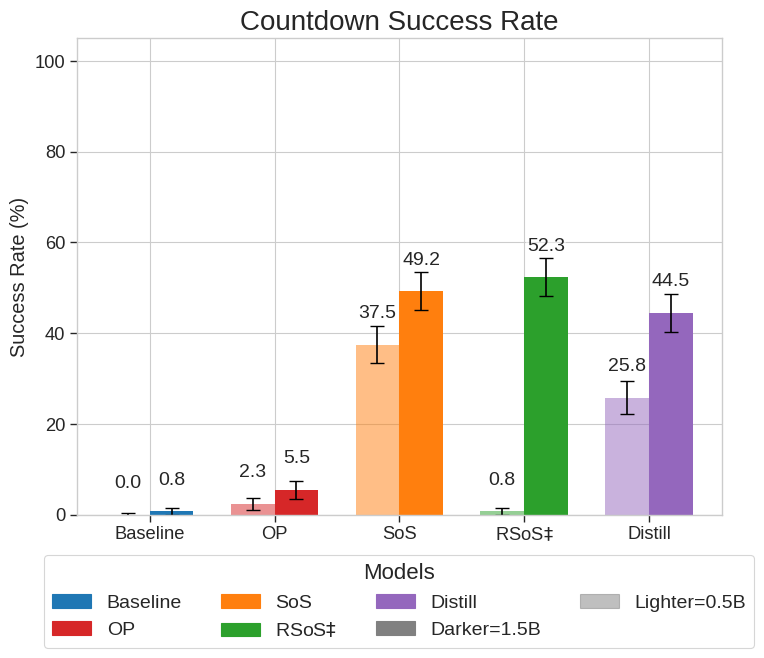

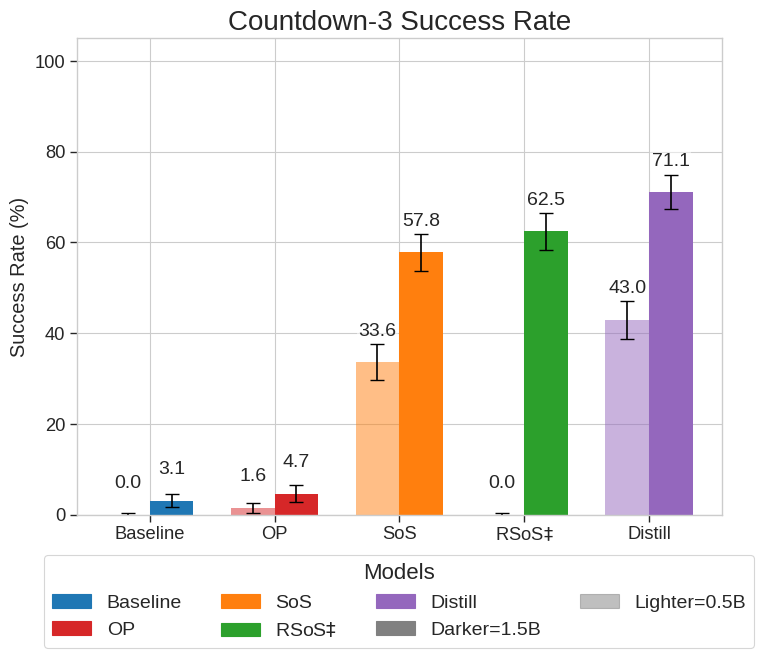

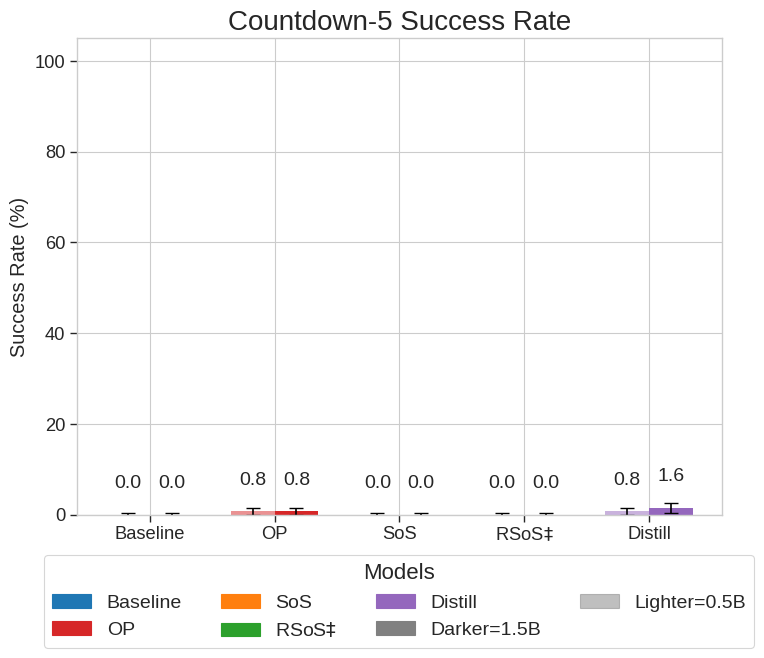

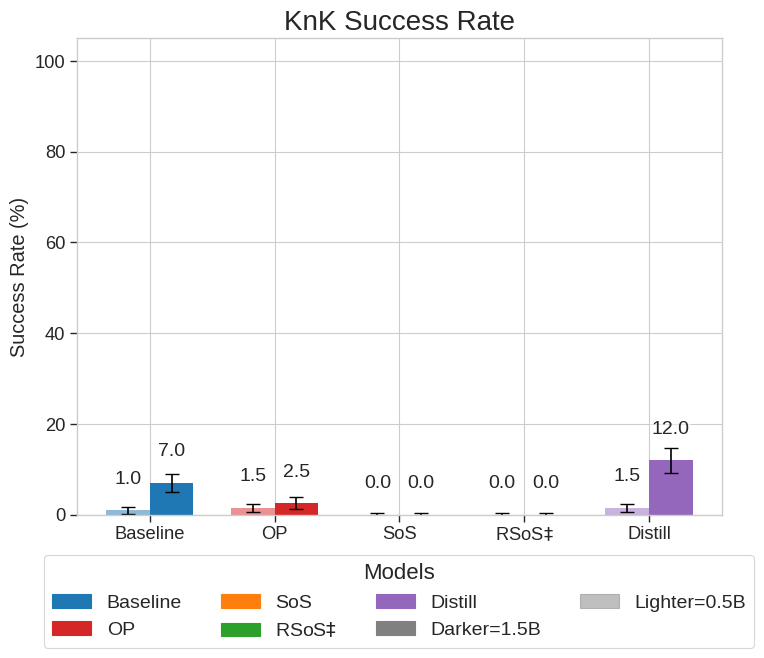

All plots saved to the 'images/' directory


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import os

# Create images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Set style for scientific publication
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

# Transform the nested dictionary into a DataFrame for plotting
df_records = []
for size in results:
    for method in results[size]:
        for task in results[size][method]:
            if results[size][method][task] is not None:
                df_records.append({
                    'model_size': size,
                    'method': method,
                    'task': task,
                    'perc_success': results[size][method][task],
                    'total_rows': 128  # Assuming 128 as default based on task names
                })
filtered_df = pd.DataFrame(df_records)

# Define method order and colors
method_order = ['Baseline', 'OP', 'SoS', "RSoS$\u2021$", 'Distill']
method_colors = {
    'Baseline': '#1f77b4',  # blue
    'OP': '#d62728',        # red 
    'SoS': '#ff7f0e',       # orange
    'RSoS$\u2021$': '#2ca02c',      # green
    'Distill': '#9467bd',   # purple
}



# Plot for each task
for task_to_plot in tasks.keys():
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Filter DataFrame to keep only the task we're interested in
    plot_df = filtered_df[filtered_df['task'] == task_to_plot]
    
    # Set x-axis with specified order
    x = np.arange(len(method_order))
    width = 0.35  # Width of bars
    
    # Plot bars for 0.5B and 1.5B models
    for i, size in enumerate(['0.5B', '1.5B']):
        subset = plot_df[plot_df['model_size'] == size]
        values = []
        errors = []
        
        for method in method_order:
            method_data = subset[subset['method'] == method]
            if len(method_data) > 0:
                # Extract the value
                value = method_data['perc_success'].values[0]
                # Calculate CI
                total = method_data['total_rows'].values[0]
                
                # Calculate confidence interval
                success = (value / 100) * total
                error = binomial_ci(success, total)
                
                values.append(value)
                errors.append(error)
            else:
                values.append(0)
                errors.append(0)
        
        # Plot with appropriate color and opacity
        opacity = 0.5 if size == '0.5B' else 1.0
        for j, method in enumerate(method_order):
            if j < len(values):  # Check if we have data for this method
                ax.bar(j + (i - 0.5) * width, values[j], width, 
                      color=method_colors[method], alpha=opacity,
                      label=f'{method} {size}' if j == 0 else "", 
                      yerr=errors[j], capsize=5)
    
    # Customize the plot
    ax.set_ylabel('Success Rate (%)')
    ax.set_title(f"{task_to_plot} Success Rate", fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(method_order)
    
    # Ensure y-axis starts at 0 and stays within bounds
    ax.set_ylim(0, 105)  # Cap at 105% for visibility
    
    # Custom legend
    handles, labels = [], []
    # First add method colors
    for method in method_order:
        handles.append(plt.Rectangle((0,0),1,1, color=method_colors[method]))
        labels.append(method)
    # Then add size indicators
    handles.append(plt.Rectangle((0,0),1,1, color='gray', alpha=1.0))
    handles.append(plt.Rectangle((0,0),1,1, color='gray', alpha=0.5))
    labels.append('Darker=1.5B')
    labels.append('Lighter=0.5B')
    
    # Place legend below the subplots
    ax.legend(handles=handles, labels=labels, loc='lower center', ncol=4, 
               bbox_to_anchor=(0.5, -0.3), fontsize=14, frameon=True, 
               title='Models', title_fontsize=16)
    
    # Add value labels on top of bars
    for i, size in enumerate(['0.5B', '1.5B']):
        subset = plot_df[plot_df['model_size'] == size]
        for j, method in enumerate(method_order):
            method_data = subset[subset['method'] == method]
            if len(method_data) > 0:
                value = method_data['perc_success'].values[0]
                ax.text(j + (i - 0.5) * width, value + 5, f'{value:.1f}', 
                    ha='center', va='bottom', fontsize=14,
                    bbox=dict(facecolor='white', alpha=0.5, pad=1, edgecolor='none'))
    
    plt.tight_layout()
    
    # Save the figure
    clean_task_name = task_to_plot.replace('-', '_').replace(' ', '_')
    fig.savefig(f'images/{clean_task_name}_success_rate.pdf', format='pdf', dpi=300, bbox_inches='tight')
    fig.savefig(f'images/{clean_task_name}_success_rate.png', format='png', dpi=150, bbox_inches='tight')
    
    # Display the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)

print(f"All plots saved to the 'images/' directory")

In [2]:
# Wilson score interval (more appropriate for proportions)
z = stats.norm.ppf(1 - (1 - confidence) / 2)  # Two-tailed z-score
p = success / total

# Calculate Wilson score interval
denominator = 1 + z**2/total
center = (p + z**2/(2*total)) / denominator
margin = z * np.sqrt((p*(1-p) + z**2/(4*total)) / total) / denominator

# Return just the margin of error
return margin * 100  # Convert to percentage

NameError: name 'stats' is not defined

In [10]:
sizes = ["1.5B"]

methods = {
    "No rejection \nsampling": "qwen-2.5-x.5B-instruct-sft-lora-countdown-search-react-seq10k-5k",
    "With rejection \nsampling": "qwen-2.5-x.5B-instruct-sft-lora-countdown-search-react-correct-seq10k-5k"
}

tasks = {
    "Countdown:": "test_128", 
}

results = {size: {method_key: {task_key: None for task_key in tasks.keys()} for method_key in methods.keys()} for size in sizes}
for size_val in sizes:
    for method_key, method_val in methods.items():
        for task_key, task_val in tasks.items():
            folder_to_look_for = f"./{method_val}/{task_val}*.json".replace("x.5B", size_val) 
            specific_file = glob.glob(folder_to_look_for)
            if specific_file:
                results[size_val][method_key][task_key] = parse_results_from_json(specific_file[0])
            
# above works, put their filepath in a pandas df
                
# put results in a pandas df
df = pd.DataFrame.from_dict({(i, j): results[i][j] 
                        for i in results.keys() 
                        for j in results[i].keys()},
                        orient='index')
# Tranpose
df = df.transpose()
# make the df float up to 2 decimals
df = df.round(2)
df.to_latex("results.tex", index=True, float_format="%.2f")
df

1.5B                          
           No rejection \nsampling With rejection \nsampling
Countdown:                     NaN                     52.34

In [19]:
results = {size: {method_key: {task_key: None for task_key in tasks.keys()} for method_key in methods.keys()} for size in training_sizes}
results

{'1k': {'SoS': {'Countdown:': None}, 'Distill': {'Countdown:': None}},
 '5k': {'SoS': {'Countdown:': None}, 'Distill': {'Countdown:': None}}}

In [21]:
training_sizes = ["1k", "5k"]

methods = {
    "SoS": "qwen-2.5-1.5B-instruct-sft-lora-countdown-search",
    "Distill": "qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k"
}

tasks = {
    "Countdown:": "test_128", 
}

results = {size: {method_key: {task_key: None for task_key in tasks.keys()} for method_key in methods.keys()} for size in training_sizes}
for size_val in training_sizes:
    for method_key, method_val in methods.items():
        for task_key, task_val in tasks.items():
            folder_to_look_for = f"./{method_val}*{size_val}/{task_val}*.json"
            specific_file = glob.glob(folder_to_look_for)
            if specific_file:
                results[size_val][method_key][task_key] = parse_results_from_json(specific_file[0])
            
# above works, put their filepath in a pandas df
                
# put results in a pandas df
df = pd.DataFrame.from_dict({(i, j): results[i][j] 
                        for i in results.keys() 
                        for j in results[i].keys()},
                        orient='index')
# Tranpose
df = df.transpose()
# make the df float up to 2 decimals
df = df.round(2)
df.to_latex("1k-vs-5k.tex", index=True, float_format="%.2f")
df

1k             5k        
              SoS Distill    SoS Distill
Countdown:  32.81   31.25  52.34   44.53

In [41]:
# load json
with open("/cs/student/msc/ml/2024/ycheah/projects/sos/stream-of-search/results/qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-5k/test_128_20250406-195241.json", 'r') as f:
    data = json.load(f)
    
i = 22
print(f"Solved: {data[i]['parsed_results']['solved']} \n", data[i]['completion'])

Solved: False 
 system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [59, 1, 92, 34] using only arithmetic operations (+, -, *, /) to reach the target value 53. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```

Note that the solution does exist. Verify your solutions before your present your final results and backtrack to correct mistakes from before your mistakes if you have to.

assistant
Okay, let's see. I need to combine the numbers 59, 1, 92, and 34 using each exactly once with arithmetic operations to get 53. Hmm. Let me start by thinking about possible combinations.

First, maybe subtract some big numbers? Like 92 minus something. 92 - 59 is 33. Then we have 33 plus 

In [ ]:
sizes = ["0.5B", "1.5B"]

methods = {
    "Without verification": "qwen-2.5-x.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-5k/no-backtrack",
    "With verification": "qwen-2.5-x.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-5k"
}

tasks = {
    "Countdown": "test_128", 
    "Countdown-3": "countdown_3num_128", 
    "Countdown-5": "countdown_5num_128",
    "KnK": "knk"
}

results = {size: {method_key: {task_key: None for task_key in tasks.keys()} for method_key in methods.keys()} for size in sizes}
for size_val in sizes:
    for method_key, method_val in methods.items():
        for task_key, task_val in tasks.items():
            folder_to_look_for = f"./{method_val}/{task_val}*.json".replace("x.5B", size_val) 
            specific_file = glob.glob(folder_to_look_for)
            if specific_file:
                results[size_val][method_key][task_key] = parse_results_from_json(specific_file[0])
            
# put results in a pandas df
df = pd.DataFrame.from_dict({(i, j): results[i][j] 
                        for i in results.keys() 
                        for j in results[i].keys()},
                        orient='index')

# Create teacher_df with same structure as df (using MultiIndex)
teacher_results = {
    "Countdown": {"Without verification": 68.0, "With verification": 78.0},
    "Countdown-3": {}, 
    "Countdown-5": {},
    "KnK": {}
}

# Create teacher_df with proper structure - (model, method) as index, tasks as columns
teacher_data = {}
for method in ["Without verification", "With verification"]:
    teacher_data[("Teacher", method)] = {task: teacher_results[task].get(method, pd.NA) for task in tasks.keys()}

teacher_df = pd.DataFrame.from_dict(teacher_data, orient='index')

# Now both df and teacher_df have the same structure - combine them
combined_df = pd.concat([df, teacher_df])

# Reorder to put Teacher results first
model_order = ["Teacher", "0.5B", "1.5B"]
method_order = ["Without verification", "With verification"]
idx = pd.MultiIndex.from_product([model_order, method_order])
combined_df = combined_df.reindex(idx)

# Clean up - remove rows with no data
combined_df = combined_df.dropna(how='all') 

# make the df float up to 2 decimals
combined_df = combined_df.round(2)
combined_df.to_latex("backtracking.tex", index=True, float_format="%.2f")
combined_df

/tmp/ipykernel_546305/2749351876.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([df, teacher_df])


Countdown  Countdown-3  Countdown-5   KnK
Teacher Without verification      68.00          NaN          NaN   NaN
        With verification         78.00          NaN          NaN   NaN
0.5B    Without verification      21.09        35.94         0.00   0.0
        With verification         25.78        42.97         0.78   1.5
1.5B    Without verification      37.50        71.09         0.78  10.0
        With verification         44.53        71.09         1.56  12.0